In [2]:
from pytfa.io.json import load_json_model
from skimpy.io.yaml import  load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.core.parameters import ParameterValues
from skimpy.utils.namespace import *
from skimpy.core.modifiers import *
from skimpy.io.yaml import load_yaml_model
from skimpy.core.reactor import Reactor
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.viz.plotting import timetrace_plot
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
from skimpy.core.parameters import load_parameter_population
from skimpy.simulations.reactor import make_batch_reactor
from skimpy.core.solution import ODESolutionPopulation
from skimpy.utils.namespace import *
from skimpy.viz.escher import animate_fluxes, plot_fluxes
import copy
from skimpy.io.yaml import export_to_yaml
from skimpy.analysis.ode.utils import make_flux_fun

import pandas as pd
import numpy as np

#import seaborn as sns
import skimpy
import time
import matplotlib.pyplot as plt
import itertools
import matplotlib
import sys
sys.path.insert(1, '../functions/')

# benchmark functions
import simulation_functions as sf
import scenarios as sc
import visualizations as vis
import noise as noise
import comb_sampling as cs


#ML methods
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import  AdaBoostRegressor
from scipy.stats import linregress

from skopt import BayesSearchCV
import seaborn as sns

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
def find_set_designs(comb_space,tcart,enz_names):
    """finds the training or test set designs in the combinatorial space
    Number of features has to be given
    - combinatorial space
    - cart of either the training scenario or the test set
    - enzyme names"""
    temp=0
    tset = pd.DataFrame()
    for design in tcart:
        sub=comb_space
        sub=sub.loc[sub['vmax_forward_Enzyme_A']==design[0]]
        sub=sub.loc[sub['vmax_forward_Enzyme_B']==design[1]]
        sub=sub.loc[sub['vmax_forward_Enzyme_C']==design[2]]
        sub=sub.loc[sub['vmax_forward_Enzyme_D']==design[3]]
        sub=sub.loc[sub['vmax_forward_Enzyme_E']==design[4]]
        sub=sub.loc[sub['vmax_forward_Enzyme_F']==design[5]]
        sub=sub.loc[sub['vmax_forward_Enzyme_G']==design[6]]
        tset=pd.concat([tset,sub])
    return tset,tcart


## DBTL cycle 1

In [5]:
#Load simulations
comb_space=pd.read_csv("../data/combinatorial_space/combinatorial_space_pathway_A.csv")

#enzyme names and perturbation range
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range)
N_designs=50
noise_percentage=0.04

In [6]:
# Latin hypercube sampling
cyc1_designs,cyc1_cart=sc.scenario1(perturb_range,N_designs,enz_names)

training_cyc1,training_cart=find_set_designs(comb_space,cyc1_cart,enz_names) 

#add noise
noise_G=noise.add_homoschedastic_noise(training_cyc1['Enzyme_G'],noise_percentage)
training_cyc1['Enzyme_G']=noise_G

#training and test split
train_x=training_cyc1[enz_names]
train_y=training_cyc1['Enzyme_G']
test_x=comb_space[enz_names]
test_y=comb_space['Enzyme_G']

In [7]:
#random forest 
regr_rf = BayesSearchCV(
GradientBoostingRegressor(),
{
    "min_samples_split":(2,3,4,5,6,7),
    "min_samples_leaf":(2,3,4,5,6,7),
    "max_depth": (1,2,3,4,5,7),
},
n_iter=15,
cv=5)
regr_rf.fit(train_x,train_y)
print(regr_rf.best_estimator_)
predict_rf=regr_rf.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
score_rf=r_value**2


GradientBoostingRegressor(max_depth=1, min_samples_leaf=4, min_samples_split=3)


In [8]:
pred_rf=regr_rf.predict(test_x)
top100=np.argsort(test_y)[::-1][0:100]
top100_rf=np.argsort(pred_rf)[::-1][0:100]

top100_rf=len(np.intersect1d(top100,top100_rf))
print(score_rf)
print(top100_rf)

0.6444939796054998
0


## Some visualization
So for this first run, no top 100 design is found. Then, we use a new distribution to sample from.


Three ideas:
1. Set threshold based on the reduction of the search space (so given the cumulative distribution, set threshold by using frequencies 
2. Set threshold based on probability distribution from feature importance function.
3. Just predict a top X and then sample from this list


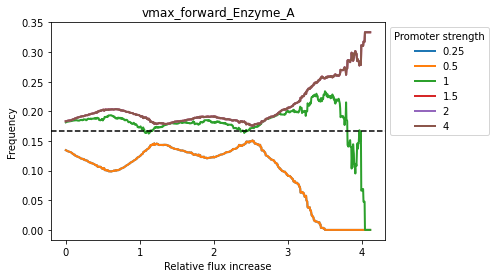

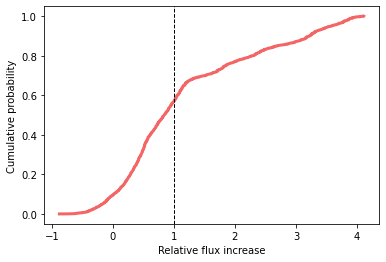

In [9]:
pred_comb_space=comb_space.copy()
pred_comb_space['Enzyme_G']=predict_rf.copy()

threshold,matrix_pred,remaining_designs_pred=cs.scan_combinatorial_space(pred_comb_space,
                                                                         perturb_range,enz_names,0.005)
#plot=sns.kdeplot(pred_rf,c="#42B540FF",label="Random Forest",linewidth=3)

A025=[]
A05=[]
A1=[]
A15=[]
A2=[]
A4=[]

#Rows are perturbation ranges (0.25,0.5,1,1.5,2,4)
#Columns are enzymes

enz=0
for i in range(np.shape(matrix_pred)[2]):
    A025.append(matrix_pred[0,enz,i])
    A05.append(matrix_pred[1,enz,i])
    A1.append(matrix_pred[2,enz,i])
    A15.append(matrix_pred[3,enz,i])
    A2.append(matrix_pred[4,enz,i])
    A4.append(matrix_pred[5,enz,i])
    
    
plt.plot(threshold,A025,label="0.25",linewidth=2)
plt.plot(threshold,A05,label="0.5",linewidth=2)
plt.plot(threshold,A1,label="1",linewidth=2)
plt.plot(threshold,A15,label="1.5",linewidth=2)
plt.plot(threshold,A2,label="2",linewidth=2)
plt.plot(threshold,A4,label="4",linewidth=2)
#plt.plot(threshold,remaining_designs,c="black",label="Remaining designs space",linewidth=3,linestyle="--")
plt.axhline(1/6,c="black",linestyle="--")
plt.legend(title="Promoter strength",bbox_to_anchor=(1.,1))
plt.ylabel("Frequency")
plt.xlabel("Relative flux increase")
plt.title(str(enz_names[enz]))
plt.show()

# evaluate the histogram
values, base = np.histogram(pred_rf, bins=10000)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative/len(comb_space['Enzyme_G']), c='#ED000099',linewidth=3)
plt.xlabel("Relative flux increase")
plt.ylabel("Cumulative probability")
plt.axvline(1,c="black",linestyle="--",linewidth=1)
plt.show()


In [11]:
enz_numbers,sorted_entropies,probability_matrix=cs.get_feature_importance(matrix_pred,pred_comb_space)

## DBTL cycle 2

In [254]:
#Given the probability distribution, make new designs
cyc2_designs,cyc2_cart=sc.manual_scenario(perturb_range,N_designs,probability_matrix,enz_names)


training_cyc2,training_cart=find_set_designs(comb_space,cyc2_cart,enz_names) 

#add noise
noise_G=noise.add_homoschedastic_noise(training_cyc2['Enzyme_G'],noise_percentage)
training_cyc2['Enzyme_G']=noise_G
dfs=[training_cyc1,training_cyc2]
training_cyc=pd.concat(dfs)

#training and test split
train_x=training_cyc[enz_names]
train_y=training_cyc['Enzyme_G']


In [255]:
#random forest 
regr_rf = BayesSearchCV(
GradientBoostingRegressor(),
{
    "min_samples_split":(2,3,4,5,6,7),
    "min_samples_leaf":(2,3,4,5,6,7),
    "max_depth": (1,2,3,4,5,7),
},
n_iter=15,
cv=5)
regr_rf.fit(train_x,train_y)
print(regr_rf.best_estimator_)
predict_rf=regr_rf.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
score_rf=r_value**2

GradientBoostingRegressor(max_depth=4, min_samples_leaf=3, min_samples_split=6)


In [256]:
pred_rf=regr_rf.predict(test_x)
top100=np.argsort(test_y)[::-1][0:100]
top100_rf=np.argsort(pred_rf)[::-1][0:100]

top100_rf=len(np.intersect1d(top100,top100_rf))
print(score_rf)
print(top100_rf)

0.8081238981589358
0


In [257]:
pred_comb_space=comb_space.copy()
pred_comb_space['Enzyme_G']=predict_rf.copy()

threshold,matrix_pred,remaining_designs_pred=cs.scan_combinatorial_space(pred_comb_space,
                                                                         perturb_range,enz_names,0.005)
enz_numbers,sorted_entropies,probability_matrix=cs.get_feature_importance(matrix_pred,pred_comb_space)

## DBTL cycle 3

In [258]:
#Given the probability distribution, make new designs
cyc3_designs,cyc3_cart=sc.manual_scenario(perturb_range,N_designs,probability_matrix,enz_names)


training_cyc3,training_cart=find_set_designs(comb_space,cyc3_cart,enz_names) 

#add noise
noise_G=noise.add_homoschedastic_noise(training_cyc3['Enzyme_G'],noise_percentage)
training_cyc3['Enzyme_G']=noise_G
dfs=[training_cyc1,training_cyc2,training_cyc3]
training_cyc=pd.concat(dfs)

#training and test split
train_x=training_cyc[enz_names]
train_y=training_cyc['Enzyme_G']

In [259]:
#random forest 
regr_rf = BayesSearchCV(
GradientBoostingRegressor(),
{
    "min_samples_split":(2,3,4,5,6,7),
    "min_samples_leaf":(2,3,4,5,6,7),
    "max_depth": (1,2,3,4,5,7),
},
n_iter=15,
cv=5)
regr_rf.fit(train_x,train_y)
print(regr_rf.best_estimator_)
predict_rf=regr_rf.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
score_rf=r_value**2

GradientBoostingRegressor(max_depth=7, min_samples_leaf=6, min_samples_split=6)


In [260]:
pred_rf=regr_rf.predict(test_x)
top100=np.argsort(test_y)[::-1][0:100]
top100_rf=np.argsort(pred_rf)[::-1][0:100]

top100_rf=len(np.intersect1d(top100,top100_rf))
print(score_rf)
print(top100_rf)

0.8781505295772729
0


In [261]:
pred_comb_space=comb_space.copy()
pred_comb_space['Enzyme_G']=predict_rf.copy()

threshold,matrix_pred,remaining_designs_pred=cs.scan_combinatorial_space(pred_comb_space,
                                                                         perturb_range,enz_names,0.005)
enz_numbers,sorted_entropies,probability_matrix=cs.get_feature_importance(matrix_pred,pred_comb_space)

## DBTL cycle 4

In [262]:
#Given the probability distribution, make new designs
cyc4_designs,cyc4_cart=sc.manual_scenario(perturb_range,N_designs,probability_matrix,enz_names)


training_cyc4,training_cart=find_set_designs(comb_space,cyc4_cart,enz_names) 

#add noise
noise_G=noise.add_homoschedastic_noise(training_cyc4['Enzyme_G'],noise_percentage)
training_cyc4['Enzyme_G']=noise_G
dfs=[training_cyc1,training_cyc2,training_cyc3,training_cyc4]
training_cyc=pd.concat(dfs)

#training and test split
train_x=training_cyc[enz_names]
train_y=training_cyc['Enzyme_G']

In [263]:
#random forest 
regr_rf = BayesSearchCV(
GradientBoostingRegressor(),
{
    "min_samples_split":(2,3,4,5,6,7),
    "min_samples_leaf":(2,3,4,5,6,7),
    "max_depth": (1,2,3,4,5,7),
},
n_iter=15,
cv=5)
regr_rf.fit(train_x,train_y)
print(regr_rf.best_estimator_)
predict_rf=regr_rf.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
score_rf=r_value**2

GradientBoostingRegressor(max_depth=7, min_samples_leaf=6, min_samples_split=6)


In [264]:
pred_rf=regr_rf.predict(test_x)
top100=np.argsort(test_y)[::-1][0:100]
top100_rf=np.argsort(pred_rf)[::-1][0:100]

top100_rf=len(np.intersect1d(top100,top100_rf))
print(score_rf)
print(top100_rf)

pred_comb_space=comb_space.copy()
pred_comb_space['Enzyme_G']=predict_rf.copy()

threshold,matrix_pred,remaining_designs_pred=cs.scan_combinatorial_space(pred_comb_space,
                                                                         perturb_range,enz_names,0.005)
#plot=sns.kdeplot(pred_rf,c="#42B540FF",label="Random Forest",linewidth=3)


0.8903156062089853
63


## DBTL cycle 5

In [265]:
#Given the probability distribution, make new designs
cyc5_designs,cyc5_cart=sc.manual_scenario(perturb_range,N_designs,probability_matrix,enz_names)


training_cyc5,training_cart=find_set_designs(comb_space,cyc5_cart,enz_names) 

#add noise
noise_G=noise.add_homoschedastic_noise(training_cyc5['Enzyme_G'],noise_percentage)
training_cyc5['Enzyme_G']=noise_G
dfs=[training_cyc1,training_cyc2,training_cyc3,training_cyc4,training_cyc5]
training_cyc=pd.concat(dfs)

#training and test split
train_x=training_cyc[enz_names]
train_y=training_cyc['Enzyme_G']

In [266]:
#random forest 
regr_rf = BayesSearchCV(
GradientBoostingRegressor(),
{
    "min_samples_split":(2,3,4,5,6,7),
    "min_samples_leaf":(2,3,4,5,6,7),
    "max_depth": (1,2,3,4,5,7),
},
n_iter=15,
cv=5)
regr_rf.fit(train_x,train_y)
print(regr_rf.best_estimator_)
predict_rf=regr_rf.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
score_rf=r_value**2

GradientBoostingRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=5)


In [267]:
pred_rf=regr_rf.predict(test_x)
top100=np.argsort(test_y)[::-1][0:100]
top100_rf=np.argsort(pred_rf)[::-1][0:100]

top100_rf=len(np.intersect1d(top100,top100_rf))
print(score_rf)
print(top100_rf)

pred_comb_space=comb_space.copy()
pred_comb_space['Enzyme_G']=predict_rf.copy()


0.8734686803313072
54


## DBTL cycle 6

In [268]:
#Given the probability distribution, make new designs
cyc6_designs,cyc6_cart=sc.manual_scenario(perturb_range,N_designs,probability_matrix,enz_names)


training_cyc6,training_cart=find_set_designs(comb_space,cyc6_cart,enz_names) 

#add noise
noise_G=noise.add_homoschedastic_noise(training_cyc6['Enzyme_G'],noise_percentage)
training_cyc6['Enzyme_G']=noise_G
dfs=[training_cyc1,training_cyc2,training_cyc3,training_cyc4,training_cyc5,training_cyc6]
training_cyc=pd.concat(dfs)

#training and test split
train_x=training_cyc[enz_names]
train_y=training_cyc['Enzyme_G']


#random forest 
regr_rf = BayesSearchCV(
GradientBoostingRegressor(),
{
    "min_samples_split":(2,3,4,5,6,7),
    "min_samples_leaf":(2,3,4,5,6,7),
    "max_depth": (1,2,3,4,5,7),
},
n_iter=15,
cv=5)
regr_rf.fit(train_x,train_y)
print(regr_rf.best_estimator_)
predict_rf=regr_rf.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
score_rf=r_value**2

pred_rf=regr_rf.predict(test_x)
top100=np.argsort(test_y)[::-1][0:100]
top100_rf=np.argsort(pred_rf)[::-1][0:100]

top100_rf=len(np.intersect1d(top100,top100_rf))
print(score_rf)
print(top100_rf)

pred_comb_space=comb_space.copy()
pred_comb_space['Enzyme_G']=predict_rf.copy()

GradientBoostingRegressor(max_depth=4, min_samples_leaf=6, min_samples_split=6)
0.8833718527788356
74


# Developing code

In [13]:
#Load simulations
comb_space=pd.read_csv("../data/combinatorial_space/combinatorial_space_pathway_A.csv")

#enzyme names and perturbation range
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range)
N_designs=50
noise_percentage=0.04


params={
    "initial_sampling_strategy":"equal",
    "combinatorial_space": comb_space,
    "noise_model":"homoschedastic",
    "noise_percentage":0.04,
    "perturb_range":perturb_range,
    "N_designs":50,
    "ML_model": "GradientBoostingRegressor",
    "probability_matrix":probability_matrix,
    "enz_names":enz_names}


def add_training_data(training_df,params):
    """Adds data to the already existing DBTL training data"""
    cyc_designs,cyc_cart=sc.manual_scenario(perturb_range,N_designs,probability_matrix,enz_names)
    training_cyc,training_cart=find_set_designs(comb_space,cyc_cart,enz_names) 
    
    #add noise
    if noise_model=="homoschedastic":
        noise_G=noise.add_homoschedastic_noise(training_cyc['Enzyme_G'],noise_percentage)
    elif noise_model=="heteroschedastic":
        noise_G=noise.add_heteroschedastic_noise(training_cyc['Enzyme_G'],noise_percentage)
    
    training_cyc['Enzyme_G']=noise_G
    dfs=[training_df,training_cyc]
    training_df=pd.concat(dfs)
    #training and test split
    train_x=training_df[enz_names]
    train_y=training_df['Enzyme_G']
    return train_x,train_y,training_df

training_cyc,train_x,train_y=add_training_data(training_df)


def train_model(model,train_x,train_y):
    if model=="GradientBoostingRegressor":
        #random forest 
        regr_gbr = BayesSearchCV(
        GradientBoostingRegressor(),
        {
            "min_samples_split":(2,3,4,5,6,7),
            "min_samples_leaf":(2,3,4,5,6,7),
            "max_depth": (1,2,3,4,5,7),
            "learning_rate":(0.0001,0.001,0.01,0.1,0.2,0.3),
        },
        n_iter=15,
        cv=5)
        regr_gbr.fit(train_x,train_y)
    return regr_gbr


def DBTL(training_df,params):
    """Wrapper for DBTL cycle"""
    training_cyc,train_x,train_y=add_training_data(training_df,params['combinatorial_space'],params['homoschedas'])
    
    
    training_cyc,train_x,train_y=add_training_data(training_cyc,
                                                   comb_space,"homoschedastic",0.02,perturb_range,
                                                   N_designs,probability_matrix,enz_names)
    regr_gbr=train_model(ML_model)
    

NameError: name 'training_df' is not defined

168197    0.298500
113816    1.043851
192218    0.774568
81676     0.269450
165641    0.118267
            ...   
153654    5.596438
253980    5.980164
269328    8.509840
256116    8.750218
279652    0.760971
Name: Enzyme_G, Length: 350, dtype: float64

In [271]:
np.shape

<function numpy.shape(a)>